In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import openslide
import random
import cv2
import matplotlib
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu

from torch.utils.data import Dataset
from tqdm import tqdm

/mnt/c/Users/33631/Documents/Etudes/centrale 3A/Deep Learning for medical Imaging/prostate_cancer_detection/new_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
train_set_path = "Data/raw_data/train.csv"
test_set_path = "Data/raw_data/test.csv"
test_images_folder = "Data/raw_data/test/test/"
train_images_folder = "Data/raw_data/train/train/"
train_mask_folder = "Data/raw_data/train_label_masks/train_label_masks/"
train_tiles_folder = "Data/processed_data/tiles_train/"

### Road Map:

we will predict the gleason scores and then convert it to isup grade

## Usefull stuff

In [16]:
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

## Load data and explore data

In [17]:
initial_train_set = pd.read_csv(train_set_path)
test_set = pd.read_csv(test_set_path)

In [18]:
# let's check the correspondance between isup and gleason
(initial_train_set[['isup_grade','gleason_score']]
    .groupby('isup_grade')
    .agg({'gleason_score': lambda x: x.unique()})
)

,gleason_score
isup_grade,
0,"[negative, 0+0]"
1,[3+3]
2,[3+4]
3,[4+3]
4,"[4+4, 3+5, 5+3]"
5,"[5+4, 4+5, 5+5]"


In [8]:
# count isup grades
(initial_train_set[['isup_grade','gleason_score']]
    .groupby('isup_grade')
    .count()
)

,gleason_score
isup_grade,
0,85
1,85
2,37
3,45
4,42
5,46


In [9]:
# image provider
(initial_train_set[['data_provider','gleason_score']]
    .groupby('data_provider')
    .count()
)

,gleason_score
data_provider,
karolinska,194
radboud,146


## Prepare Data

In [19]:
validation_ratio = 0.2

X = initial_train_set.drop(columns = ['gleason_score', 'isup_grade'])
y = initial_train_set[['isup_grade','gleason_score']]
train_samples, validation_samples, train_labels, validation_labels = train_test_split(X,y, test_size=validation_ratio, random_state=0, shuffle=True, stratify=y)

train_set = pd.concat([train_samples, train_labels], axis = 1)
validation_set = pd.concat([validation_samples, train_labels], axis = 1)

In [11]:
train_set.sample(3)

,image_id,data_provider,isup_grade,gleason_score
122,b788300a50ab73f893b63ce6a9c08f9d,radboud,1,3+3
15,4b746fda943de9f7e620be0933bc9d27,karolinska,1,3+3
50,8c64bb74f16d4a6c44c9b8ea5dee8543,radboud,1,3+3


## Visualisations

In [12]:
def visualise_mask_and_image(id, level = 3): # last level by default
    line = train_set.iloc[id]

    data_provider = line.data_provider
    isup_grade = line.isup_grade
    gleason_score = line.gleason_score
    image_id = line.image_id

    image = openslide.OpenSlide(train_images_folder+image_id+'.tiff')
    print(image.level_dimensions)
    image_data = image.read_region((0,0), image.level_count - 1, image.level_dimensions[-1])
    try:
        mask = openslide.OpenSlide(train_mask_folder+image_id+'.tiff')
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
    except:
        print('no mask for this image')
        mask = None
        mask_data = None


    fig, axes = plt.subplots(1,2, figsize=(8,8))
    axes[0].imshow(image_data)
    axes[1].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)

    title = f"gleason score: {gleason_score} - isup grade: {isup_grade} \n data provider: {data_provider}"
    fig.suptitle(title, fontsize=14)
    
    mask.close()
    image.close()
    fig.tight_layout()
    plt.show()


((18924, 33498), (4731, 8374), (1182, 2093))


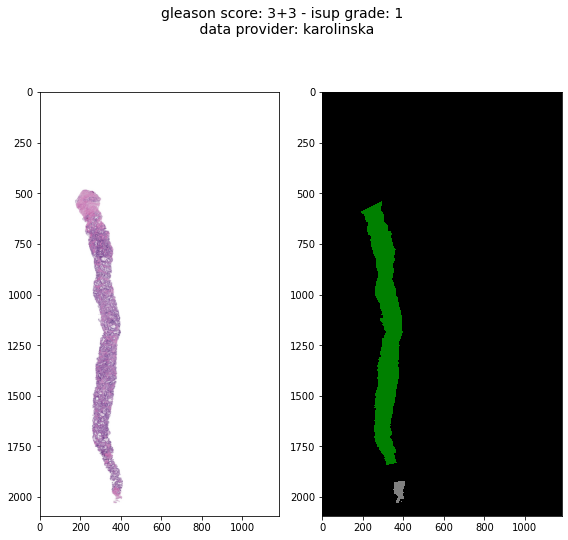

In [13]:
visualise_mask_and_image(1)

((9472, 22016), (2368, 5504), (592, 1376))


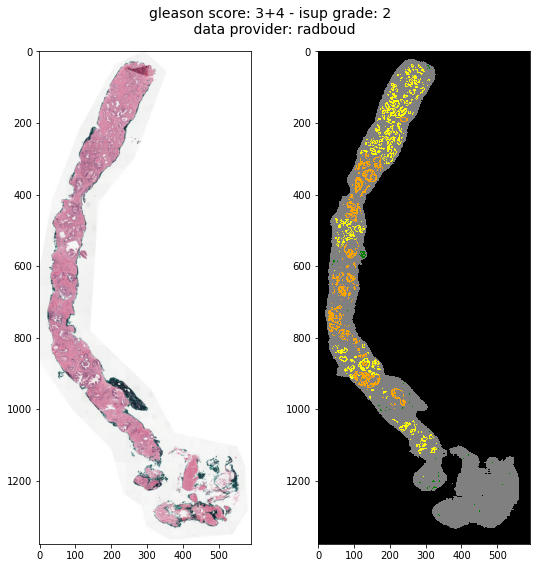

In [14]:
visualise_mask_and_image(2)

((21912, 23507), (5478, 5876), (1369, 1469))


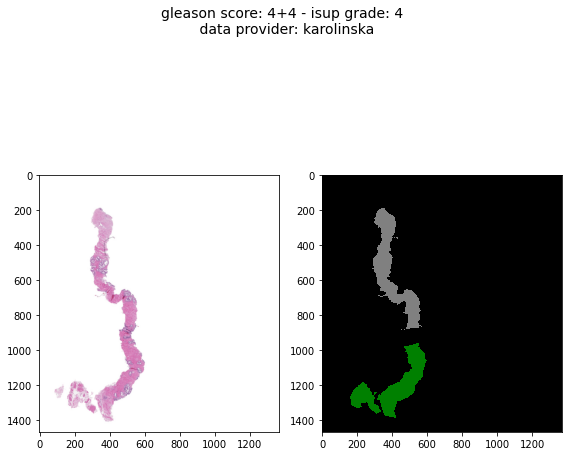

In [15]:
visualise_mask_and_image(15)

In [64]:
def get_tiles(image, n_tiles = 16, tile_shape = 128, level = 1):
    dimensions = image.level_dimensions[level]
    img = np.array(image.read_region((0,0), level, dimensions))
    offset_0 = tile_shape-dimensions[1]%tile_shape
    offset_1 = tile_shape-dimensions[0]%tile_shape

    pad_0 = (offset_0//2, offset_0//2+offset_0%tile_shape%2)
    pad_1 = (offset_1//2, offset_1//2+offset_1%2)
    img = np.pad(img, pad_width = (pad_0, pad_1, (0,0)), mode = 'constant',constant_values = 255)

    img = img.reshape(img.shape[0] // tile_shape, tile_shape, img.shape[1] // tile_shape, tile_shape, 4)
    img = img.transpose(0,2,1,3,4).reshape(-1, tile_shape, tile_shape, 4)


    indexes = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:n_tiles]
    tiles  = img[indexes]
    new_image = np.zeros(((n_tiles//4)*128,(n_tiles//4)*128,4))
    for i in range(tiles.shape[0]):
        col = i%(n_tiles//4)
        row = i//(n_tiles//4)
        new_image[row*128:(row+1)*128,col*128:(col+1)*128,:] = tiles[i]
    new_image = new_image.astype('uint8')
    return(new_image)

In [26]:
from PIL import Image
def create_tiles(df):
    for i in tqdm(range(df.shape[0]), position = 0):
        value = df.iloc[i]
        id = value.image_id
        if os.path.isfile(train_tiles_folder+id+".jpeg"):
            continue
        print(id)
        image = openslide.OpenSlide(train_images_folder+id+".tiff")
        tile_image = get_tiles(image)
        tile_image = Image.fromarray(tile_image)
        tile_image = tile_image.convert('RGB')
        tile_image.save(train_tiles_folder+id+".jpeg")
        image.close()


In [183]:
create_tiles(train_set)

  0%|          | 0/272 [00:00<?, ?it/s]

61b39e218e57b00f7453dff2837fa16b


  0%|          | 1/272 [00:05<25:02,  5.54s/it]

(8497, 4785, 4)


ValueError: cannot reshape array of size 162632580 into shape (66,128,37,128,4)

In [62]:
level = 1
tile_shape = 128
n_tiles = 16
image = openslide.OpenSlide(train_images_folder+"3d3de59a9cdafdb58eb5ffde8dab8d70.tiff")

dimensions = image.level_dimensions[level]
img = np.array(image.read_region((0,0), level, dimensions))

offset_0 = tile_shape-dimensions[1]%tile_shape
offset_1 = tile_shape-dimensions[0]%tile_shape

pad_0 = (offset_0//2, offset_0//2+offset_0%tile_shape%2)

pad_1 = (offset_1//2, offset_1//2+offset_1%2)
img = np.pad(img, pad_width = (pad_0, pad_1, (0,0)), mode = 'constant', constant_values = 255)
img = img.reshape(img.shape[0] // tile_shape, tile_shape, img.shape[1] // tile_shape, tile_shape, 4)
img = img.transpose(0,2,1,3,4).reshape(-1, tile_shape, tile_shape, 4)


indexes = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:n_tiles]
tiles  = img[indexes]
new_image = np.zeros(((n_tiles//4)*128,(n_tiles//4)*128,4))
for i in range(tiles.shape[0]):
    col = i%(n_tiles//4)
    row = i//(n_tiles//4)
    new_image[row*128:(row+1)*128,col*128:(col+1)*128,:] = tiles[i]
new_image = new_image.astype('uint8')

In [48]:
level = 1
dimensions = image.level_dimensions[level]
a = image.read_region((0,0), level, dimensions)



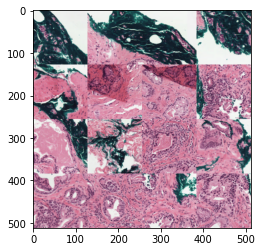

In [63]:
plt.imshow(new_image)

In [50]:
type(a)

PIL.Image.Image

In [232]:
n_tiles = 16
tile_shape = 128

In [269]:
image = openslide.OpenSlide(train_images_folder+"0c16dad59425c963a1dba7a84638ece7.tiff")
level =1
dimensions = image.level_dimensions[level]
img = np.array(image.read_region((0,0), level, dimensions).convert('1'))
offset_0 = tile_shape-dimensions[1]%tile_shape
offset_1 = tile_shape-dimensions[0]%tile_shape

pad_0 = (offset_0//2, offset_0//2+offset_0%tile_shape%2)
pad_1 = (offset_1//2, offset_1//2+offset_1%2)
img = np.pad(img, pad_width = (pad_0, pad_1, (0,0)), mode = 'constant')
'''
img = img.reshape(img.shape[0] // tile_shape, tile_shape, img.shape[1] // tile_shape, tile_shape, 4)
img = img.transpose(0,2,1,3,4).reshape(-1, tile_shape, tile_shape, 4)


indexes = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:n_tiles]
tiles  = img[indexes]
new_image = np.zeros(((n_tiles//4)*128,(n_tiles//4)*128,4))
for i in range(tiles.shape[0]):
    col = i%(n_tiles//4)
    row = i//(n_tiles//4)
    new_image[row*128:(row+1)*128,col*128:(col+1)*128,:] = tiles[i]
#new_image = new_image.astype('uint8')
'''

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,2)  and requested shape (2,2)

In [270]:
np.max(img)

True

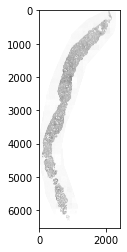

In [272]:
plt.imshow(img, cmap = "gray")

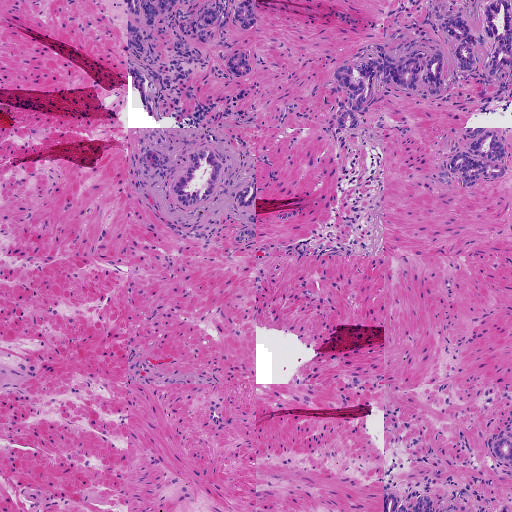

In [174]:
tile_image = Image.fromarray(a)
tile_image.convert('RGB')

In [ ]:
class TilesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample